In [1]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

config = load_config('./HBiLSTM_CL.json')

In [3]:
class DocumentDataset(Dataset):
    def __init__(self, file_path):
        self.l_mapper = {
        "Fact": 0,
        "ArgumentPetitioner": 1,
        "ArgumentRespondent": 1,
        "RulingByPresentCourt": 2,
        "RulingByLowerCourt": 3,
        "RatioOfTheDecision": 4,
        "None": -1,
        "Statute": 5,
        "PrecedentReliedUpon": 6,
        "PrecedentNotReliedUpon": 6,
        "PrecedentOverruled": 6,
        "Issue": 0,
        "Dissent": 0
        }
        self.file_path = file_path
        self.documents = self.load_documents()
        
    def load_documents(self):
        with open(self.file_path, "rb") as file:
            data_dict = pickle.load(file)
        return [(doc_name, doc_data) for doc_name, doc_data in data_dict.items()]

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        doc_name, doc_data = self.documents[index]
        embeddings = doc_data["embeddings"]
        labels = doc_data["labels"]
        
        mapped_labels = [self.l_mapper[label] for label in labels]
        mapped_labels = torch.tensor(mapped_labels, device = torch.device("cpu"))
        
        return doc_name, torch.tensor(embeddings, device = torch.device("cpu")), mapped_labels


In [109]:
import torch
import torch.nn as nn

class LSTM_model(nn.Module):
    def __init__(self, num_classes, emb_dim, hidden_dim, drop=0.5, device='cpu'):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.lstm1 = nn.LSTM(emb_dim, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(drop)
        self.head = nn.Linear(hidden_dim, num_classes)
        self.device = device
    
    def forward(self, sequences):
        # Initialize hidden states for both LSTM layers
        h0 = torch.zeros(2, sequences.size(0), self.hidden_dim // 2).to(self.device)
        c0 = torch.zeros(2, sequences.size(0), self.hidden_dim // 2).to(self.device)
        
        # Pass input sequences through the first LSTM layer
        x, _ = self.lstm1(sequences, (h0, c0))
        
        # Pass output of the first LSTM layer through the second LSTM layer
        x, _ = self.lstm2(x)
        
        # Apply dropout regularization
        x = self.dropout(x)
        
        # Apply linear layer
        x = self.head(x)
        
        return x


In [110]:
cl_train_dataset = DocumentDataset('../../data/bert_sentence_independent_embeddings/CL_train.pkl')
cl_dev_dataset = DocumentDataset('../../data/bert_sentence_independent_embeddings/CL_dev.pkl')

In [111]:
cl_train_dataloader = DataLoader(cl_train_dataset, batch_size=1)
cl_dev_dataloader = DataLoader(cl_dev_dataset, batch_size=1)

In [112]:
# Example usage
hidden_dim = 120
emb_dim = 768
num_layers = 2
num_labels = 7

# Create an instance of the hierarchical model
model = LSTM_model(num_labels, emb_dim, hidden_dim)

In [113]:
lr = config['training']['learning_rate']
max_grad_norm = config['training']['max_grad_norm']
epochs = config['training']['epochs']

num_total_steps = len(cl_train_dataloader)*epochs
num_warmup_steps = config['training']['num_warmup_steps']
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1

from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=True)
#epoch_scheduler = StepLR(optimizer, step_size=1, gamma=config['training']["lr_epoch_decay"])

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_total_steps)

In [114]:
seed_val = config['training']['seed']
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [115]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cpu


LSTM_model(
  (lstm1): LSTM(768, 60, batch_first=True, bidirectional=True)
  (lstm2): LSTM(120, 60, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (head): Linear(in_features=120, out_features=7, bias=True)
)

In [116]:
total_loss = 0
total_correct = 0
total_samples = 0

# Define the number of training and validation steps
num_train_steps = len(cl_train_dataloader)
num_dev_steps = len(cl_dev_dataloader)

# Initialize lists to store losses and accuracy
train_epoch_losses = []
train_epoch_acc = []
dev_epoch_losses = []
dev_epoch_acc = []

# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    #print('Training...')
    
    model.train()  # Set the model to train mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    start_time = time.time()

    for step, batch in enumerate(cl_train_dataloader):
        doc_name, embeddings, labels = batch
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings)
        
        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
        train_loss += loss.item()
        
        # Calculate accuracy
        predicted_labels = outputs.argmax(dim=2)
        correct = (predicted_labels == labels).sum().item()
        train_correct += correct
        train_total += labels.size(0) * labels.size(1)
        
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    # Calculate epoch statistics
    train_loss /= num_train_steps
    train_accuracy = train_correct / train_total
    
    # Store epoch statistics
    train_epoch_losses.append(train_loss)
    train_epoch_acc.append(train_accuracy)
    
    # Calculate the training epoch time
    epoch_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Epoch Time: {epoch_time:.2f} seconds")
    
    # ------------------------------------------------------------------------------------
    # Validation loop
    #print('Validating...')
    
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    
    for step, batch in enumerate(cl_dev_dataloader):
        with torch.no_grad():
            doc_name, embeddings, labels = batch
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(embeddings)
            
            # Calculate loss
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            dev_loss += loss.item()
            
            # Calculate accuracy
            predicted_labels = outputs.argmax(dim=2)
            correct = (predicted_labels == labels).sum().item()
            dev_correct += correct
            dev_total += labels.size(0) * labels.size(1)
    
    # Calculate epoch statistics
    dev_loss /= num_dev_steps
    dev_accuracy = dev_correct / dev_total
    
    # Store epoch statistics
    dev_epoch_losses.append(dev_loss)
    dev_epoch_acc.append(dev_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {dev_loss:.4f} - Validation Accuracy: {dev_accuracy:.4f}")
    
    # ------------------------------------------------------------------------------------


======== Epoch 1 / 300 ========
Epoch 1/300 - Training Loss: 1.9626 - Train Accuracy: 0.1940 - Epoch Time: 3.12 seconds
Epoch 1/300 - Validation Loss: 1.9613 - Validation Accuracy: 0.2066
======== Epoch 2 / 300 ========
Epoch 2/300 - Training Loss: 1.9571 - Train Accuracy: 0.2105 - Epoch Time: 3.04 seconds
Epoch 2/300 - Validation Loss: 1.9535 - Validation Accuracy: 0.2066
======== Epoch 3 / 300 ========
Epoch 3/300 - Training Loss: 1.9467 - Train Accuracy: 0.2193 - Epoch Time: 3.02 seconds
Epoch 3/300 - Validation Loss: 1.9408 - Validation Accuracy: 0.2066
======== Epoch 4 / 300 ========
Epoch 4/300 - Training Loss: 1.9332 - Train Accuracy: 0.2355 - Epoch Time: 3.05 seconds
Epoch 4/300 - Validation Loss: 1.9230 - Validation Accuracy: 0.2066
======== Epoch 5 / 300 ========
Epoch 5/300 - Training Loss: 1.9151 - Train Accuracy: 0.2504 - Epoch Time: 3.03 seconds
Epoch 5/300 - Validation Loss: 1.9008 - Validation Accuracy: 0.2066
======== Epoch 6 / 300 ========
Epoch 6/300 - Training Loss:

Epoch 44/300 - Training Loss: 1.4039 - Train Accuracy: 0.3828 - Epoch Time: 3.01 seconds
Epoch 44/300 - Validation Loss: 1.4164 - Validation Accuracy: 0.2633
======== Epoch 45 / 300 ========
Epoch 45/300 - Training Loss: 1.4015 - Train Accuracy: 0.3813 - Epoch Time: 3.00 seconds
Epoch 45/300 - Validation Loss: 1.4134 - Validation Accuracy: 0.2690
======== Epoch 46 / 300 ========
Epoch 46/300 - Training Loss: 1.3927 - Train Accuracy: 0.3820 - Epoch Time: 3.01 seconds
Epoch 46/300 - Validation Loss: 1.3847 - Validation Accuracy: 0.2704
======== Epoch 47 / 300 ========
Epoch 47/300 - Training Loss: 1.3862 - Train Accuracy: 0.3782 - Epoch Time: 3.01 seconds
Epoch 47/300 - Validation Loss: 1.3962 - Validation Accuracy: 0.2948
======== Epoch 48 / 300 ========
Epoch 48/300 - Training Loss: 1.3928 - Train Accuracy: 0.3790 - Epoch Time: 3.00 seconds
Epoch 48/300 - Validation Loss: 1.3697 - Validation Accuracy: 0.2941
======== Epoch 49 / 300 ========
Epoch 49/300 - Training Loss: 1.3779 - Train 

Epoch 87/300 - Training Loss: 1.2396 - Train Accuracy: 0.4087 - Epoch Time: 3.00 seconds
Epoch 87/300 - Validation Loss: 1.2864 - Validation Accuracy: 0.2855
======== Epoch 88 / 300 ========
Epoch 88/300 - Training Loss: 1.2473 - Train Accuracy: 0.4050 - Epoch Time: 3.04 seconds
Epoch 88/300 - Validation Loss: 1.3644 - Validation Accuracy: 0.2841
======== Epoch 89 / 300 ========
Epoch 89/300 - Training Loss: 1.2212 - Train Accuracy: 0.3940 - Epoch Time: 3.05 seconds
Epoch 89/300 - Validation Loss: 1.2943 - Validation Accuracy: 0.2912
======== Epoch 90 / 300 ========
Epoch 90/300 - Training Loss: 1.2322 - Train Accuracy: 0.4017 - Epoch Time: 3.04 seconds
Epoch 90/300 - Validation Loss: 1.3266 - Validation Accuracy: 0.3013
======== Epoch 91 / 300 ========
Epoch 91/300 - Training Loss: 1.2230 - Train Accuracy: 0.3992 - Epoch Time: 3.08 seconds
Epoch 91/300 - Validation Loss: 1.3067 - Validation Accuracy: 0.2927
======== Epoch 92 / 300 ========
Epoch 92/300 - Training Loss: 1.2229 - Train 

Epoch 130/300 - Training Loss: 1.1557 - Train Accuracy: 0.4195 - Epoch Time: 3.01 seconds
Epoch 130/300 - Validation Loss: 1.2788 - Validation Accuracy: 0.2877
======== Epoch 131 / 300 ========
Epoch 131/300 - Training Loss: 1.1348 - Train Accuracy: 0.4994 - Epoch Time: 3.00 seconds
Epoch 131/300 - Validation Loss: 1.2945 - Validation Accuracy: 0.3336
======== Epoch 132 / 300 ========
Epoch 132/300 - Training Loss: 1.1481 - Train Accuracy: 0.4476 - Epoch Time: 2.99 seconds
Epoch 132/300 - Validation Loss: 1.3182 - Validation Accuracy: 0.3207
======== Epoch 133 / 300 ========
Epoch 133/300 - Training Loss: 1.1135 - Train Accuracy: 0.4764 - Epoch Time: 3.03 seconds
Epoch 133/300 - Validation Loss: 1.2614 - Validation Accuracy: 0.3451
======== Epoch 134 / 300 ========
Epoch 134/300 - Training Loss: 1.1492 - Train Accuracy: 0.4381 - Epoch Time: 3.01 seconds
Epoch 134/300 - Validation Loss: 1.2876 - Validation Accuracy: 0.3128
======== Epoch 135 / 300 ========
Epoch 135/300 - Training Loss:

Epoch 173/300 - Training Loss: 1.0424 - Train Accuracy: 0.5188 - Epoch Time: 3.02 seconds
Epoch 173/300 - Validation Loss: 1.2950 - Validation Accuracy: 0.3271
======== Epoch 174 / 300 ========
Epoch 174/300 - Training Loss: 1.0498 - Train Accuracy: 0.5005 - Epoch Time: 3.01 seconds
Epoch 174/300 - Validation Loss: 1.3055 - Validation Accuracy: 0.3343
======== Epoch 175 / 300 ========
Epoch 175/300 - Training Loss: 1.0457 - Train Accuracy: 0.5099 - Epoch Time: 3.00 seconds
Epoch 175/300 - Validation Loss: 1.2838 - Validation Accuracy: 0.3207
======== Epoch 176 / 300 ========
Epoch 176/300 - Training Loss: 1.0615 - Train Accuracy: 0.4980 - Epoch Time: 3.00 seconds
Epoch 176/300 - Validation Loss: 1.3157 - Validation Accuracy: 0.3436
======== Epoch 177 / 300 ========
Epoch 177/300 - Training Loss: 1.0725 - Train Accuracy: 0.4779 - Epoch Time: 3.02 seconds
Epoch 177/300 - Validation Loss: 1.3321 - Validation Accuracy: 0.3121
======== Epoch 178 / 300 ========
Epoch 178/300 - Training Loss:

Epoch 216/300 - Training Loss: 0.9708 - Train Accuracy: 0.5381 - Epoch Time: 3.03 seconds
Epoch 216/300 - Validation Loss: 1.3384 - Validation Accuracy: 0.3680
======== Epoch 217 / 300 ========
Epoch 217/300 - Training Loss: 0.9826 - Train Accuracy: 0.5619 - Epoch Time: 3.02 seconds
Epoch 217/300 - Validation Loss: 1.3866 - Validation Accuracy: 0.3508
======== Epoch 218 / 300 ========
Epoch 218/300 - Training Loss: 0.9867 - Train Accuracy: 0.5506 - Epoch Time: 3.02 seconds
Epoch 218/300 - Validation Loss: 1.3487 - Validation Accuracy: 0.3199
======== Epoch 219 / 300 ========
Epoch 219/300 - Training Loss: 0.9877 - Train Accuracy: 0.5398 - Epoch Time: 3.02 seconds
Epoch 219/300 - Validation Loss: 1.3095 - Validation Accuracy: 0.3271
======== Epoch 220 / 300 ========
Epoch 220/300 - Training Loss: 0.9815 - Train Accuracy: 0.5471 - Epoch Time: 3.01 seconds
Epoch 220/300 - Validation Loss: 1.3444 - Validation Accuracy: 0.3307
======== Epoch 221 / 300 ========
Epoch 221/300 - Training Loss:

Epoch 259/300 - Training Loss: 0.9416 - Train Accuracy: 0.5572 - Epoch Time: 3.01 seconds
Epoch 259/300 - Validation Loss: 1.3507 - Validation Accuracy: 0.3788
======== Epoch 260 / 300 ========
Epoch 260/300 - Training Loss: 0.9375 - Train Accuracy: 0.5767 - Epoch Time: 3.05 seconds
Epoch 260/300 - Validation Loss: 1.3636 - Validation Accuracy: 0.3831
======== Epoch 261 / 300 ========
Epoch 261/300 - Training Loss: 0.9455 - Train Accuracy: 0.5411 - Epoch Time: 3.07 seconds
Epoch 261/300 - Validation Loss: 1.3710 - Validation Accuracy: 0.3608
======== Epoch 262 / 300 ========
Epoch 262/300 - Training Loss: 0.9353 - Train Accuracy: 0.5571 - Epoch Time: 3.06 seconds
Epoch 262/300 - Validation Loss: 1.3465 - Validation Accuracy: 0.4067
======== Epoch 263 / 300 ========
Epoch 263/300 - Training Loss: 0.9362 - Train Accuracy: 0.5502 - Epoch Time: 3.02 seconds
Epoch 263/300 - Validation Loss: 1.3592 - Validation Accuracy: 0.3745
======== Epoch 264 / 300 ========
Epoch 264/300 - Training Loss:

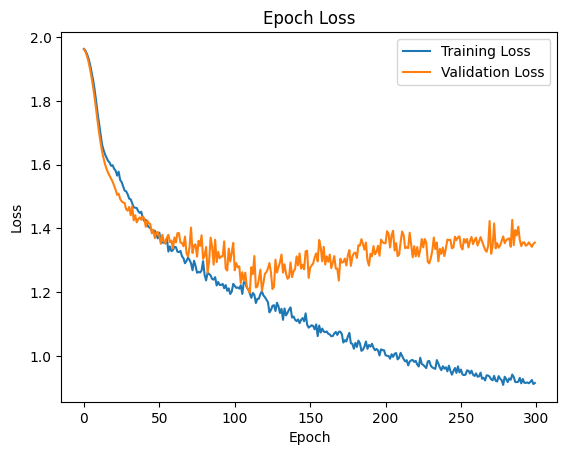

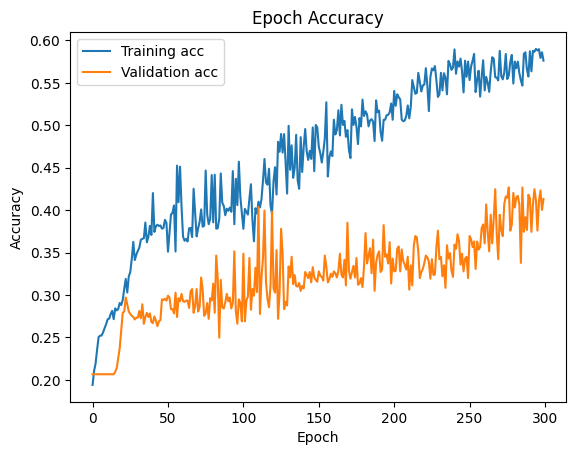

In [117]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses, label='Training Loss')
plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_acc, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [118]:
cl_test_dataset = DocumentDataset('../../data/bert_sentence_independent_embeddings/CL_test.pkl')

In [119]:
cl_test_dataloader = DataLoader(cl_test_dataset, batch_size=1)

In [120]:
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
test_correct = 0
test_total = 0

# Tracking variables 
predictions , true_labels = [], []

for step, batch in enumerate(cl_test_dataloader):
    with torch.no_grad():
        doc_name, embeddings, labels = batch
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(embeddings)

        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
        test_loss += loss.item()

        # Calculate accuracy
        predicted_labels = outputs.argmax(dim=2)
        correct = (predicted_labels == labels).sum().item()
        test_correct += correct
        test_total += labels.size(0) * labels.size(1)
        
        predictions.append(predicted_labels.to('cpu'))
        true_labels.append(labels.to('cpu'))
        
# Calculate average loss and accuracy
test_loss /= len(cl_test_dataloader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.6233 - Test Accuracy: 0.3251


In [121]:
pred_flat = torch.cat(predictions, dim=1).squeeze(0)
labels_flat = torch.cat(true_labels, dim=1).squeeze(0)

In [122]:
from sklearn.metrics import classification_report
print(classification_report(labels_flat, pred_flat))

              precision    recall  f1-score   support

           0       0.34      0.66      0.45       326
           1       0.32      0.51      0.39       201
           2       0.67      0.33      0.44        12
           3       0.00      0.00      0.00        23
           4       0.28      0.19      0.23       434
           5       0.70      0.24      0.36        86
           6       0.18      0.03      0.05       256

    accuracy                           0.33      1338
   macro avg       0.36      0.28      0.28      1338
weighted avg       0.31      0.33      0.28      1338

